# Using code from John to generate some data for test

In [1]:
# functions from John Slattery's work

import numpy as np


def linear_ramp(t, t0=0.0, dt=1.0, y0=0.0, dy=1.0, GS_slope = 0.0, GIS_slope=0.0):
    """Linear Ramp Function

    This function describes the piece-wise linear ramp.

    Parameter
    ---------
    t : np.ndarray
        Time variable
    t0 : float
        Start time of the ramp
    dt : float
        Transition length
    y0 : float
        Function value before the transition
    dy : float
        Hight of the transition
    GS_slope : float
        slope before transition - can be positive or negative
    GIS_slope : float
        slope after transition - can be positive or negative

    Return
    ------
    y : np.ndarray
        Function values of the linear transiton
    """
    lt_t0 = t < t0
    gt_t1 = t > t0 + dt
    condlist = [lt_t0,
                ~np.logical_or(lt_t0, gt_t1),
                gt_t1]
    funclist = [lambda t: y0 + GS_slope * (t - t0),
                lambda t: y0 + dy * (t - t0) / dt,
                lambda t: y0 + dy + GIS_slope * (t - t0 - dt)]
    y = np.piecewise(t, condlist, funclist)
    return y


def sample_ar1(n, alpha, sigma=1.0, x0=0):
    """Generate AR(1) noise for evenely sampled series"""
    x = np.zeros(n)
    x[0] = x0 + sigma * np.random.randn()
    sigma_e = np.sqrt(sigma ** 2 * (1 - alpha ** 2))
    for i in range(1, n):
        x[i] = alpha * x[i - 1] + sigma_e * np.random.randn()
    return x


import numpy as np

def cal_snr(signal, noise):
    """
    Calculate Signal-to-Noise Ratio (SNR) given signal and noise.

    Args:
    signal (numpy.ndarray): Signal data.
    noise (numpy.ndarray): Noise data.

    Returns:
    float: Signal-to-Noise Ratio (SNR) in decibels (dB).
    """
    signal_power = np.mean(np.square(signal))  # Calculate signal power
    noise_power = np.mean(np.square(noise))    # Calculate noise power

    # snr = 10 * (np.log10(signal_power) - np.log10(noise_power))  # Calculate SNR in dB
    snr = noise_power/signal_power  # Calculate SNR 
    return snr



import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

def gen_dummy_DO(length, delta=10.0, t0=800.0, dt=50.0, dy=1.0, GS_slope=5e-4, GIS_slope=-1e-3, tau=1.0, sigma=0.05):
    """
    Generate dummy time series data for demonstration purposes.

    Args:
    length (int): Length of the time series data.
    delta (float): Time step.
    t0 (float): Starting time.
    dt (float): Duration of the transition.
    dy (float): Amplitude of the transition.
    GS_slope (float): Slope of the Gaussian-shaped transition.
    GIS_slope (float): Slope of the Glacial-interglacial-shaped transition.
    causal_strength (float): Strength of the causal link.
    sigma (float): Standard deviation of the noise.
    tau (float): Time constant for the autoregressive process.

    Returns:
    pandas.DataFrame: DataFrame containing dummy time series data.
    """
    alpha = np.exp(-delta / tau)
    # time = np.arange(t0, t0 + length * delta, step=delta, dtype='float')
    time = np.arange(length, step=delta, dtype='float')
    trans = linear_ramp(time, t0=t0, dt=dt, y0=0.0, dy=dy, GS_slope=GS_slope, GIS_slope=GIS_slope)
    noise = sample_ar1(len(time), alpha=alpha, sigma=sigma, x0=0)
    synt_trans = trans + noise

    df = pd.DataFrame({
        'time': time,
        'A': synt_trans,
        'trans': trans
    })

    return df

def gen_linked_data(df, lag=10, causal_strength=0.5, delta=10.0, tau=1.0, sigma=0.05):
    """
    Generate causally linked synthetic data.

    Args:
    df (pandas.DataFrame): DataFrame containing synthetic time series data.
    lag (int): Lag for the causal effect. Positive lag means left shifting the series.
    causal_strength (float): Strength of the causal link.
    delta (float): Time step.
    tau (float): Time constant for the autoregressive process.
    sigma (float): Standard deviation of the noise.


    Returns:
    pandas.DataFrame: DataFrame containing causally linked synthetic data.
    """
    synt_trans = df['trans'].values
    alpha = np.exp(-delta / tau)
    # Shift the series
    if lag > 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[:-lag] = synt_trans[lag:]
    if lag < 0:
        left_shifted_synt_trans = np.full_like(synt_trans, np.nan)
        left_shifted_synt_trans[-lag:] = synt_trans[:lag]
    if lag == 0:
        left_shifted_synt_trans=synt_trans

    # Generate AR(1) noise as the base for the second causally linked dataset
    new_noise = sample_ar1(len(synt_trans), alpha=alpha, sigma=sigma, x0=0)

    # Combine the lagged original series with the new AR(1) series to produce the causally linked series
    causally_linked_synt_trans = new_noise + causal_strength * left_shifted_synt_trans

    df['B'] = causally_linked_synt_trans
    return df.dropna()



d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

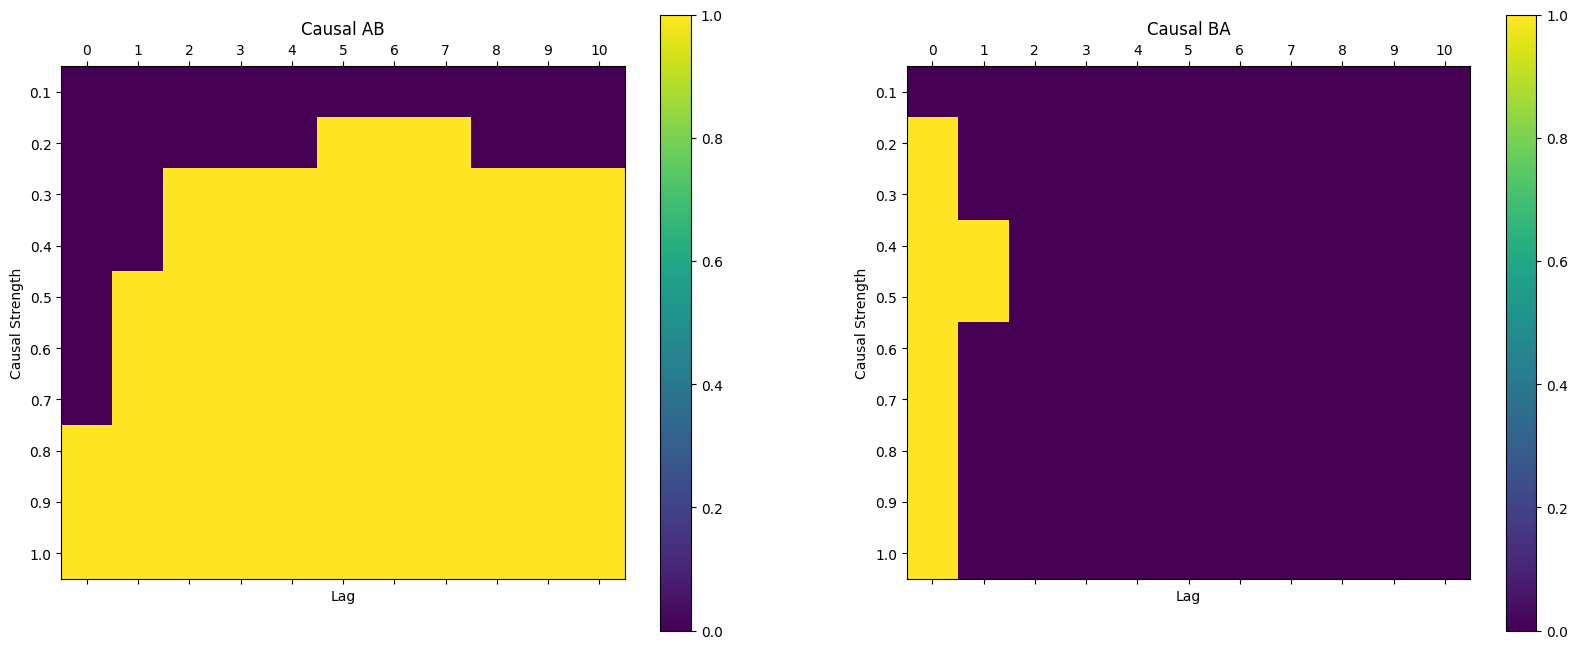

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize parameters
causal_strengths = np.arange(0.1, 1.1, 0.1)  # From 0.1 to 1.0 in steps of 0.1
lags = range(11)  # From 0 to 10
iterations = 100
causal_AB_results = np.zeros((len(causal_strengths), len(lags)))
causal_BA_results = np.zeros((len(causal_strengths), len(lags)))

# Loop through combinations of causal strengths and lags
for i, strength in enumerate(causal_strengths):
    for j, lag in enumerate(lags):
        causal_AB_true_count = 0
        causal_BA_true_count = 0
        
        for _ in range(iterations):
            # Generate dummy data and linked data
            dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.1, tau=1.0)
            dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=strength, delta=10.0, lag=lag, tau=1.0, sigma=0.1)
            
            df_gc = dummy_warming_lagged[['A', 'B']]
            
            df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
            gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
            causal_AB = gc_results_A_B[0]['XY']
            causal_BA = gc_results_A_B[0]['YX']
            
            if causal_AB:
                causal_AB_true_count += 1
            if causal_BA:
                causal_BA_true_count += 1
        
        # Calculate the percentages
        causal_AB_results[i, j] = causal_AB_true_count / iterations
        causal_BA_results[i, j] = causal_BA_true_count / iterations

        causal_AB_results[i, j]  = causal_AB_results[i, j]  >= 0.95
        causal_BA_results[i, j] = causal_BA_results[i, j] >= 0.95

# Plotting the heatmaps
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Causal_AB heatmap
cax1 = ax[0].matshow(causal_AB_results, interpolation='nearest', cmap='viridis')
fig.colorbar(cax1, ax=ax[0])
ax[0].set_title('Causal AB')
ax[0].set_xticks(np.arange(len(lags)))
ax[0].set_xticklabels(lags)
ax[0].set_yticks(np.arange(len(causal_strengths)))
ax[0].set_yticklabels(np.round(causal_strengths, 1))
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Causal Strength')

# Causal_BA heatmap
cax2 = ax[1].matshow(causal_BA_results, interpolation='nearest', cmap='viridis')
fig.colorbar(cax2, ax=ax[1])
ax[1].set_title('Causal BA')
ax[1].set_xticks(np.arange(len(lags)))
ax[1].set_xticklabels(lags)
ax[1].set_yticks(np.arange(len(causal_strengths)))
ax[1].set_yticklabels(np.round(causal_strengths, 1))
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Causal Strength')

plt.show()


In [205]:
from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

# Initialize counters for the causality results
causal_AB_true_count = 0
causal_BA_true_count = 0
iterations = 100

for _ in range(iterations):
    # Generate dummy data and linked data
    dummy_data = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.1, tau=1.0)
    dummy_warming_lagged = gen_linked_data(dummy_data, causal_strength=1, delta=10.0, lag=1, tau=1.0, sigma=0.1)
    
    # Assuming the GC.make_stationary and GC.gc4vars functions are defined in the GC_functions module
    # Simulate the stationarity check and Granger causality test
    df_gc = dummy_warming_lagged[['A', 'B']]
    
    df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
    gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19, print_results=False)
    causal_AB = gc_results_A_B[0]['XY']
    causal_BA = gc_results_A_B[0]['YX']
    
    if causal_AB:
        causal_AB_true_count += 1
    if causal_BA:
        causal_BA_true_count += 1

# Calculate the percentages
causal_AB_percentage = causal_AB_true_count / iterations
causal_BA_percentage = causal_BA_true_count / iterations

# Determine the final output based on the 95% threshold
causal_AB_final_result = causal_AB_percentage >= 0.95
causal_BA_final_result = causal_BA_percentage >= 0.95

(causal_AB_final_result, causal_BA_final_result, causal_AB_percentage, causal_BA_percentage)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_cau

(True, False, 1.0, 0.78)

Testing causality between: A and B
Granger Causality Test
------------------------------------------------------------
Direction                   F-statistics         p-value         lag         Granger cause
A => B    13.746               0.000                7                True
B => A    1.260               0.264                1                False



d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


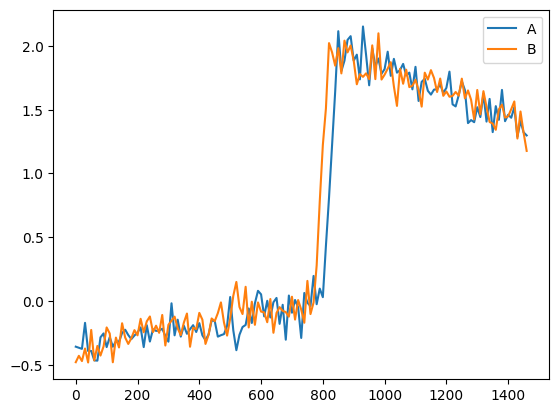

In [200]:
# Example usage:
# Generate dummy data
dummy_warming = gen_dummy_DO(length=1500, delta=10.0, t0=800.0, dt=50.0, dy=2.0, GS_slope=5e-4, GIS_slope=-1e-3, sigma=0.1, tau=1.0)
dummy_warming

# # Generate causally linked data with lag=5
dummy_warming_lagged = gen_linked_data(dummy_warming, causal_strength=1, delta=10.0, lag=3, tau=1.0, sigma=0.1)
dummy_warming_lagged


# plot the dummy_warming_lagged
import matplotlib.pyplot as plt
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['A'], label='A')
plt.plot(dummy_warming_lagged['time'], dummy_warming_lagged['B'], label='B')
# add legend
plt.legend()


# get the column A and B of the dataframe
df_gc=dummy_warming_lagged[['A','B']]
df_gc

from toolbox import GC_functions as GC  # Assuming GC_functions is your custom module

df_gc_checked = GC.make_stationary(df_gc,['A', 'B'], test_method='ADF', plot=False)
gc_results_A_B = GC.gc4vars(df_gc_checked, max_lags=19)
causal_AB = gc_results_A_B[0]['XY']
causal_BA = gc_results_A_B[0]['YX']